In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import my_utils as myu

import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
# from torch_geometric.nn import SplineConv
from torch_geometric.typing import WITH_TORCH_SPLINE_CONV
from torch_geometric.data import Data

In [2]:
# check for valid spline_conv
if not WITH_TORCH_SPLINE_CONV:
    quit("This example requires 'torch-spline-conv'")

# Check available GPUs and prepare device list
if torch.cuda.is_available():
    devices = [f'cuda:{i}' for i in range(torch.cuda.device_count())]
else:
    devices = ['cpu']  # fallback to CPU if no GPUs are available
print("Using devices:", devices)

Using devices: ['cpu']


In [3]:
# root_folder = "/ocean/projects/eng170006p/ussqww/TTNG_05052024"  
# root_folder = "E:/NeuronGrowth_2024/TTNG_05052024"  
root_folder = "./dataset/NDDs" 
vtk_pairs = myu.read_all_folders_vtk_pairs(root_folder)

Processing folder 1/2 (50.00%) completed: Reading from: ./dataset/NDDs\io2D_1c01\outputs
Processing folder 2/2 (100.00%) completed: Reading from: ./dataset/NDDs\io2D_1c02\outputs


Progress: 9.09% - Processed physics_allparticle_000000.vtk
Progress: 18.18% - Processed physics_allparticle_002000.vtk
Progress: 27.27% - Processed physics_allparticle_004000.vtk
Progress: 36.36% - Processed physics_allparticle_006000.vtk
Progress: 45.45% - Processed physics_allparticle_008000.vtk
Progress: 54.55% - Processed physics_allparticle_010000.vtk
Progress: 63.64% - Processed physics_allparticle_012000.vtk
Progress: 72.73% - Processed physics_allparticle_014000.vtk
Progress: 81.82% - Processed physics_allparticle_016000.vtk
Progress: 90.91% - Processed physics_allparticle_018000.vtk
Progress: 100.00% - Processed physics_allparticle_020000.vtk
All files processed and interpolated.
Generated 11 data pairs.


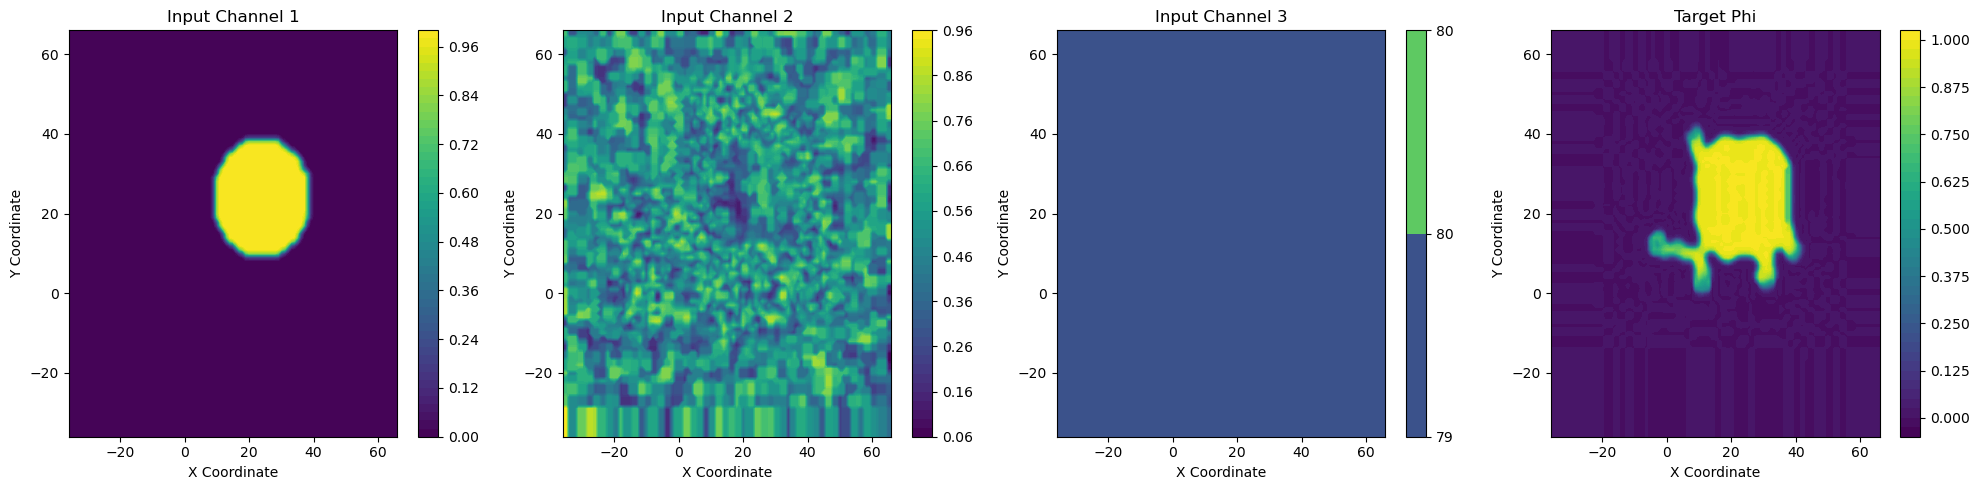

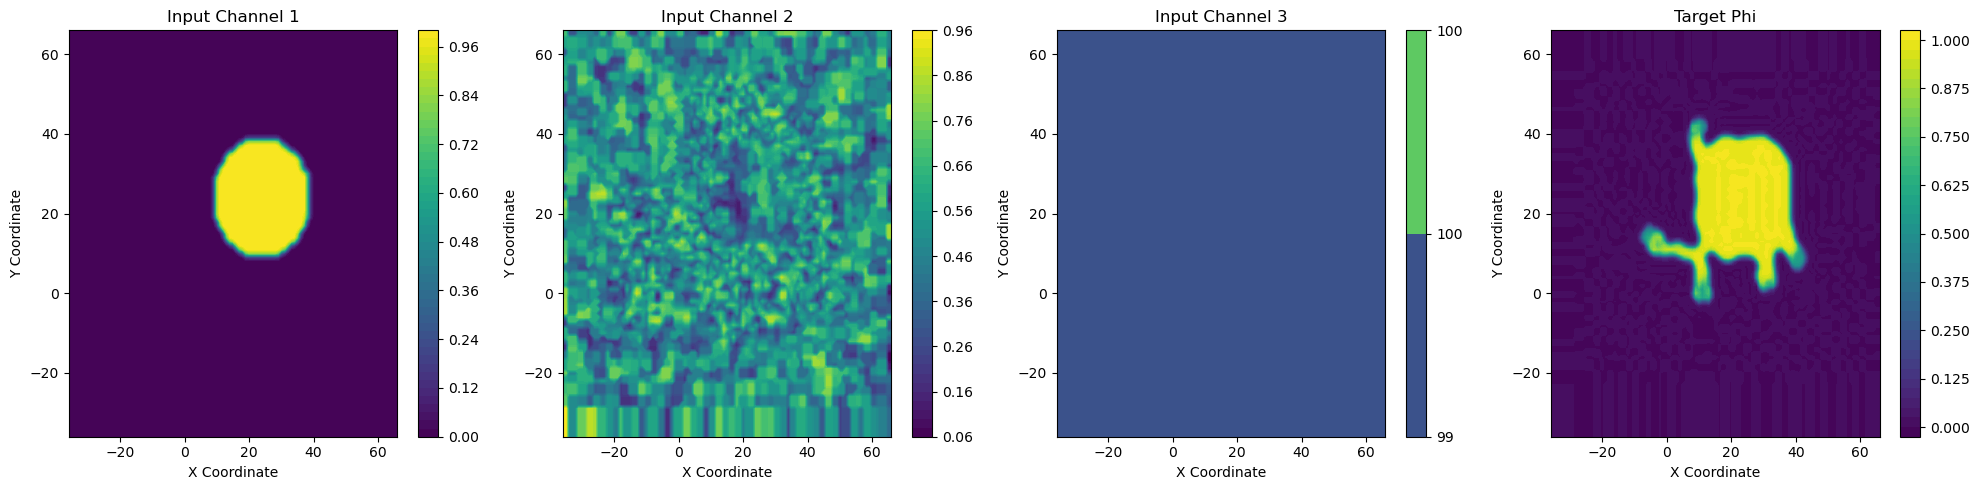

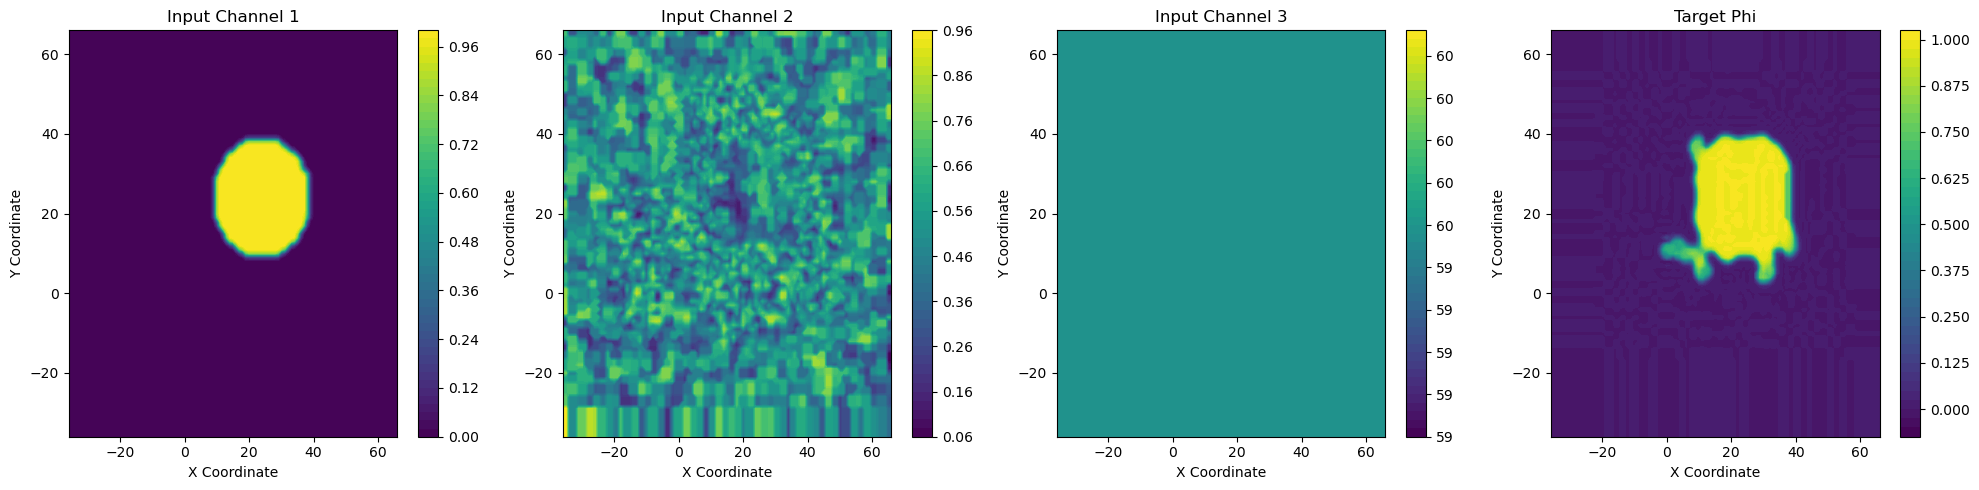

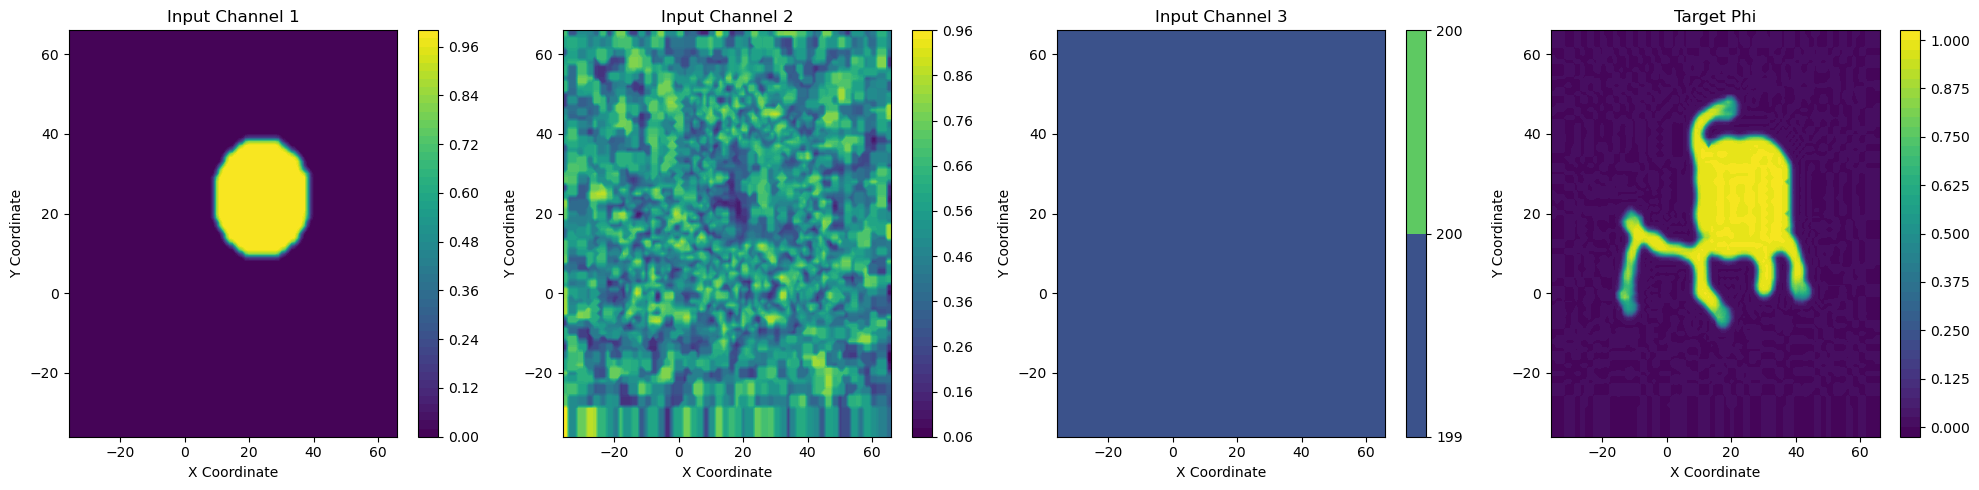

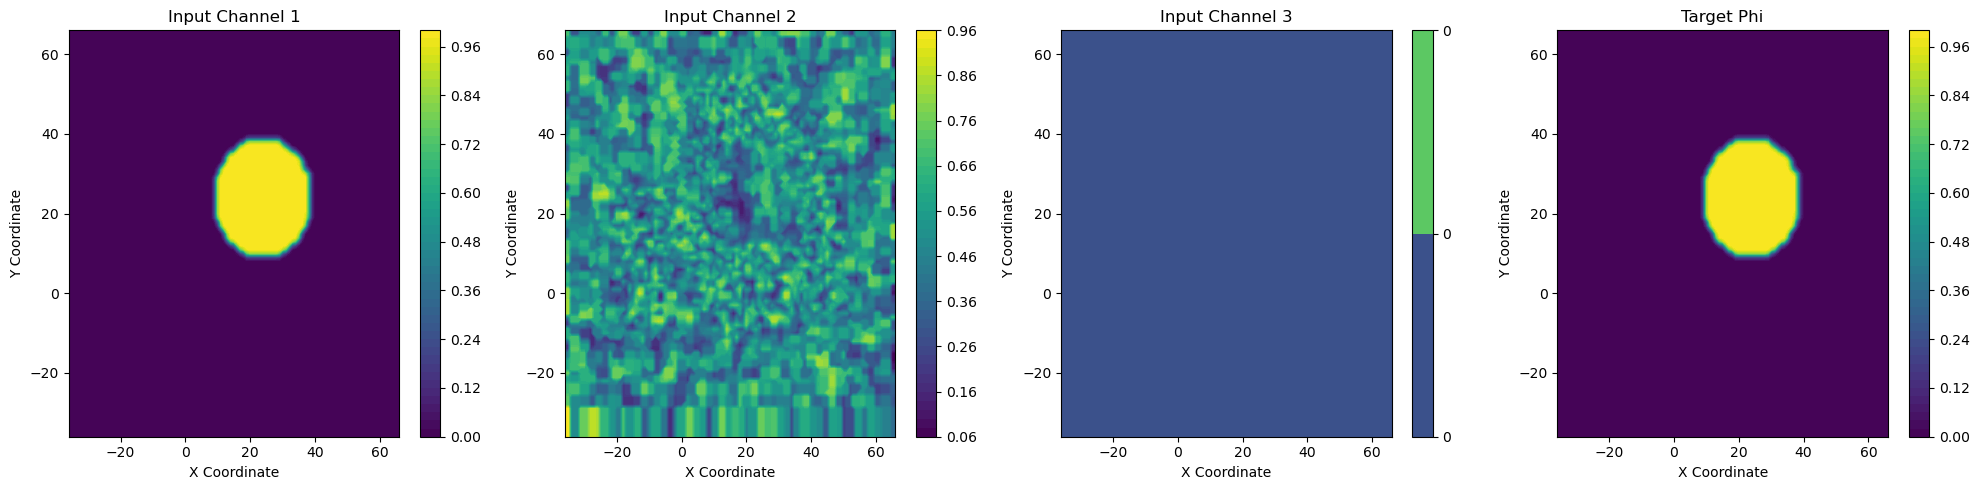

In [4]:
# Data preprocessing into strucutred square matrices for CNN mdoel
folder_path = "./dataset/NDDs/io2D_1c01/outputs" 
# # folder_path = "./dataset/NDD_per1" 
interpolated_data, grid_x, grid_y = myu.read_all_vtks_and_interpolate(folder_path)

if interpolated_data:
    try:
        data_pairs = myu.preprocess_data(interpolated_data)
        print(f"Generated {len(data_pairs)} data pairs.")
        myu.plot_data_pairs(data_pairs, grid_x, grid_y, 5)
    except Exception as e:
        print(f"Error preparing data: {e}")

    # plot_interpolated_data(interpolated_data, grid_x, grid_y)

In [ ]:
graph_data_list = myu.create_graphs_from_datasets(vtk_pairs)

# # Assuming `graph_data_list` is already created
# torch.save(graph_data_list, './generated_data/graph_data_list.pth')
# # Load the graph data list
# graph_data_list = torch.load('./generated_data/graph_data_list.pth')

In [ ]:
random_index = random.randint(0, len(graph_data_list) - 1)
graph_data = graph_data_list[random_index]
points = graph_data.x.numpy()[:, :2]
features = graph_data.x.numpy()[:, 2:]  # All features from index 2 to end
edges = graph_data.edge_index.numpy().T
edge_attr = graph_data.edge_attr.numpy()  # Assuming edge_attr contains vector components for each edge
y = graph_data.y.numpy()  # Assuming y contains target values or another feature for each node

myu.plot_graph_components_with_highlights(points, features, edges, edge_attr, y)

In [ ]:
data = myu.combine_graph_data(graph_data_list)

# data.x = data.x[:,:3]
# Print details about the combined graph data
print("Combined Graph Data:")
print(data)

In [ ]:
if torch.isnan(data.x).any() or torch.isnan(data.y).any():
    print("NaNs found in the dataset")
if torch.isinf(data.x).any() or torch.isinf(data.y).any():
    print("Infs found in the dataset")

In [ ]:
print('Before removing nodes based on phi values')
print(data)
data = myu.remove_nodes(data, threshold=0.01)
print('After removing nodes based on phi values')
print(data)

In [ ]:
print('Before removing NaN and Inf nodes')
print(data)
data = myu.remove_nans_and_infs(data)
print('After removing NaN and Inf nodes')
print(data)

In [ ]:
# Ensure y (labels) is of shape [num_nodes]
data.y = data.y.view(-1)  # Ensure y is 1D [num_nodes]

# Number of nodes in the graph
num_nodes = data.x.size(0)  # Infer the number of nodes from x
num_train = int(num_nodes * 0.8)  # 80% of nodes for training
num_test = num_nodes - num_train  # 20% of nodes for testing

# Randomly permute node indices to create random train, validation, and test splits
perm = torch.randperm(num_nodes)

# Initialize masks for train and test sets
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Assign masks based on the random permutation
train_mask[perm[:num_train]] = True
test_mask[perm[num_train:]] = True

# Assign masks to the Data object
data.train_mask = train_mask
data.test_mask = test_mask

# Optional: Create a validation mask from the training set
num_val = int(num_train * 0.1)  # 10% of the training set for validation
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[perm[:num_val]] = True

# Assign validation mask to the Data object
data.val_mask = val_mask

data.num_classes = 2  # Assuming your problem is binary classification

data.y = data.y.float()
# Print the final structured data object
print(data)

In [ ]:
# data.x[:, 2] = np.round(data.x[:, 2], decimals=2)

data.x = data.x[:, :3]

data.y = np.round(data.y)

In [ ]:
# Normalize features
data.x = myu.min_max_normalize_features(data.x)
data.edge_attr = myu.min_max_normalize_features(data.edge_attr)
data.y = myu.min_max_normalize_features(data.y)

# # Add gradient features
# data = add_gradient_features(data, data.edge_index)
# print('Done adding gradient features')

# # Optionally, rotate points for augmentation
# data = rotate_points(data, 45)  # Rotate by 45 degrees
# print('Done rotating points')

# # Oversample minority class to balance the dataset
# data = oversample_minority_class(data)
# print('Done oversampling minority class')

# Print data to verify changes
print(data)

In [ ]:
myu.plot_features_and_target(data)

In [ ]:
# Example check for NaNs in your data
if torch.isnan(data.x).any() or torch.isnan(data.y).any():
    print("NaNs found in the dataset")

In [ ]:
# !mkdir ./generated_data
# # Assuming 'data' is your PyTorch Geometric Data object
# torch.save(data, './generated_data/NDD.pt')
# # Load a single data object
# data = torch.load('./generated_data/NDD_per1000.pt')

In [ ]:
print(data)
print(max(data.x[:,2]))
print(data.x)
print(max(data.y))
print(data.y)

plt.hist(data.y.numpy(), bins=50)
plt.title('Histogram of Model Output Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

myu.print_random_y_values(data)

In [ ]:
print(data)

In [ ]:
def check_tensor(tensor, name="Tensor"):
    if torch.isnan(tensor).any() or torch.isinf(tensor).any():
        print(f"{name} contains NaN or Inf.")

# Example usage in your training loop
check_tensor(data.x, "Input Features")

In [ ]:
# check and printout device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

print(data)

# GPU Memory Monitoring Function
def print_gpu_memory(device):
    torch.cuda.synchronize(device)
    allocated = torch.cuda.memory_allocated(device)
    reserved = torch.cuda.memory_reserved(device)
    print(f"Allocated memory: {allocated / (1024**3):.3f} GB")
    print(f"Reserved memory: {reserved / (1024**3):.3f} GB")

from NeuralNetworks import SplineCNN_SuperPixelNet, Net, GCNNet, GATNet, HybridGAT_SplineNet, train, test
# Initialize the Net model
# model = SplineCNN_SuperPixelNet(data)
model = Net(data)  # Instantiate the model with the data
# model = GCNNet(data)
# model = GATNet(data)
# model = HybridGAT_SplineNet(data)

# Initialize weights
def weights_init(m):
    if hasattr(m, 'weight') and hasattr(m.weight, 'data'):
        torch.nn.init.xavier_uniform_(m.weight.data)
    if hasattr(m, 'bias') and m.bias is not None:
        torch.nn.init.constant_(m.bias.data, 0.0)

# # Apply weights initialization
# model.apply(weights_init)

# Move to the appropriate device
model = model.to(device)
data = data.to(device)

# Set up the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)

# Lists to store training and test accuracy for each epoch
train_acc_list = []
test_acc_list = []

for epoch in range(1, 201):
    train()
    train_acc, test_acc = test()
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Test: {test_acc:.4f}')

    if epoch % 20 == 0:
        !nvidia-smi
        print_gpu_memory(device)

In [ ]:
# Plot the convergence of training and test accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, len(test_acc_list) + 1), test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Convergence Plot')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
@torch.no_grad()
def evaluate_model_regression(data, model):
    model.eval()
    out = model(data)
    
    actual = data.y[data.test_mask]
    print(actual.size())
    
    # # Calculate Mean Squared Error
    # mse = F.mse_loss(out[data.test_mask], actual)
    # print(f'Test MSE: {mse.item():.4f}')

    # Ensure output is within the [0, 1] range using sigmoid (if not already applied in the model)
    out_prob = torch.sigmoid(out[data.test_mask]).squeeze()  # Apply sigmoid to ensure the outputs are probabilities.
    # Calculate Binary Cross-Entropy
    bce = F.binary_cross_entropy(out_prob, actual)
    print(f'Test BCE: {bce.item():.4f}')

    # Print sample predictions for checking
    print("\nSample Predictions:")
    num_samples = min(10, out[data.test_mask].size(0))
    for i in range(num_samples):
        print(f'Predicted: {out[data.test_mask][i].item():.4f}, Actual: {actual[i].item():.4f}')

evaluate_model_regression(data, model)

In [ ]:
@torch.no_grad()
def evaluate_model_regression(data, model):
    model.eval()
    out = model(data)
    
    actual = data.y[data.test_mask]
    print(actual.size())
    
    # Ensure output is within the [0, 1] range using sigmoid (if not already applied in the model)
    out_prob = torch.sigmoid(out[data.test_mask]).squeeze()  # Apply sigmoid to ensure the outputs are probabilities.
    
    # Calculate Binary Cross-Entropy
    bce = F.binary_cross_entropy(out_prob, actual)
    print(f'Test BCE: {bce.item():.4f}')

    # Calculate accuracy for the entire test dataset
    # predicted_labels = (out_prob > 0.7).int()  # Apply threshold to convert probabilities to binary labels
    predicted_labels = out_prob  # Apply threshold to convert probabilities to binary labels
    correct_predictions = (predicted_labels == actual).float().sum().item()  # Calculate the number of correct predictions
    total_predictions = actual.size(0)  # Total number of predictions
    accuracy = correct_predictions / total_predictions  # Calculate accuracy
    print(f'Test Accuracy: {accuracy:.4f}')

    # Print sample predictions for checking
    print("\nSample Predictions:")
    num_samples = min(20, actual.size(0))  # Limit number of samples to print
    if num_samples > 0:
        sample_indices = torch.randperm(actual.size(0))[:num_samples]  # Randomly pick indices to print
        for i in sample_indices:
            predicted_label = predicted_labels[i].item()
            out_prob_val = out_prob[i].item()
            actual_val = actual[i].item()
            print(f'Pred label: {predicted_label}, Out prob: {out_prob_val:.4f}, Actual: {actual_val:.0f}')

    plt.hist(out_prob.detach().cpu().numpy(), bins=50)
    plt.title('Histogram of Model Output Probabilities')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.show()

evaluate_model_regression(data, model)

In [ ]:
@torch.no_grad()
def evaluate_model(data, model, rotation_angle_degrees=-45, num_samples=100):
    model.eval()
    out = model(data)
    
    # Get all test indices
    test_indices = torch.where(data.test_mask)[0]
    
    # Randomly sample from the test indices if the number is greater than num_samples
    if len(test_indices) > num_samples:
        sampled_indices = test_indices[torch.randperm(len(test_indices))[:num_samples]]
    else:
        sampled_indices = test_indices

    # out_prob = torch.sigmoid(out[sampled_indices].squeeze())  # Apply sigmoid to ensure the outputs are probabilities
    # threshold = 0.7  # Define the threshold
    # pred = (out_prob > threshold).int()  # Convert probabilities to binary labels based on the threshold
    pred = torch.sigmoid(out[sampled_indices].squeeze())
    actual = data.y[sampled_indices]
    input_phi = data.x[sampled_indices, 2]  # Assuming the third column is phi
    error = (pred - actual).abs()  # Calculate error as absolute difference

    # # Calculate accuracy for the sampled cases
    # correct = pred.round().eq(actual.round()).sum().item()
    # total = len(sampled_indices)
    # accuracy = correct / total
    # print(f'Test Accuracy (sampled): {accuracy:.4f} for {num_samples} samples')

    # Reverse the rotation for visualization purposes
    angle = np.radians(rotation_angle_degrees)
    rotation_matrix = np.array([
        [np.cos(angle), np.sin(angle)],
        [-np.sin(angle), np.cos(angle)]
    ])

    coords = data.x[sampled_indices][:, :2].cpu().numpy()  # Ensure the first two columns are coordinates
    new_coords = np.dot(coords, rotation_matrix)

    # Visualization of 2D predictions
    fig, ax = plt.subplots(1, 4, figsize=(28, 7), sharex=True, sharey=True)
    scatter = ax[0].scatter(new_coords[:, 0], new_coords[:, 1], c=input_phi.cpu().numpy(), cmap='viridis', s=50)
    ax[0].set_title('Input Phi')
    ax[0].set_xlabel('X Coordinate')
    ax[0].set_ylabel('Y Coordinate')
    plt.colorbar(scatter, ax=ax[0], label='Input Phi Value')

    scatter = ax[1].scatter(new_coords[:, 0], new_coords[:, 1], c=pred.cpu().numpy(), cmap='viridis', s=50)
    ax[1].set_title('Predicted Phi')
    ax[1].set_xlabel('X Coordinate')
    plt.colorbar(scatter, ax=ax[1], label='Predicted Class')

    scatter = ax[2].scatter(new_coords[:, 0], new_coords[:, 1], c=actual.cpu().numpy(), cmap='viridis', s=50)
    ax[2].set_title('Actual Phi')
    ax[2].set_xlabel('X Coordinate')
    plt.colorbar(scatter, ax=ax[2], label='Actual Class')

    # Error visualization
    scatter = ax[3].scatter(new_coords[:, 0], new_coords[:, 1], c=error.cpu().numpy(), cmap='viridis', s=50)
    ax[3].set_title('Absolute error')
    ax[3].set_xlabel('X Coordinate')
    plt.colorbar(scatter, ax=ax[3], label='Error')

    plt.show()

evaluate_model(data, model, 0, num_samples=1000)

In [ ]:
# # credits:
# # how to use DDP module with DDP sampler: https://gist.github.com/sgraaf/5b0caa3a320f28c27c12b5efeb35aa4c
# # how to setup a basic DDP example from scratch: https://pytorch.org/tutorials/intermediate/dist_tuto.html
# import os
# import torch
# import torch.distributed as dist
# import torch.multiprocessing as mp
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torchvision import datasets, transforms
# import random

# from torch.nn.parallel import DistributedDataParallel as DDP

# from torch.utils.data import DataLoader, Dataset
# from torch.utils.data.distributed import DistributedSampler
# import math

# def get_dataset():
#     world_size = dist.get_world_size()
#     train_set = datasets.MNIST('./data', train=True, download=True,
#                              transform=transforms.Compose([
#                                  transforms.ToTensor(),
#                                  transforms.Normalize((0.1307,), (0.3081,))
#                              ]))
#     val_set = datasets.MNIST('./data', train=False, download=True,
#                              transform=transforms.Compose([
#                                  transforms.ToTensor(),
#                                  transforms.Normalize((0.1307,), (0.3081,))
#                              ]))
    
#     train_sampler = DistributedSampler(train_set,num_replicas=world_size)
#     val_sampler = DistributedSampler(val_set,num_replicas=world_size)
#     batch_size = int(128 / float(world_size))
#     print(world_size, batch_size)
#     train_loader = DataLoader(
#         dataset=train_set,
#         sampler=train_sampler,
#         batch_size=batch_size
#     )
#     val_loader = DataLoader(
#         dataset=val_set,
#         sampler=val_sampler,
#         batch_size=batch_size
#     )

#     return train_loader, val_loader, batch_size
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 10)
#         self.softmax = nn.LogSoftmax(dim=1)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         x = x.view(-1, 320)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         x = self.softmax(x)
#         return x
# def average_gradients(model):
#     size = float(dist.get_world_size())
#     for param in model.parameters():
#         dist.all_reduce(param.grad.data, op=dist.ReduceOp.SUM)
#         param.grad.data /= size
# def reduce_dict(input_dict, average=True):
#     world_size = float(dist.get_world_size())
#     names, values = [], []
#     for k in sorted(input_dict.keys()):
#         names.append(k)
#         values.append(input_dict[k])
#     values = torch.stack(values, dim=0)
#     dist.all_reduce(values, op=dist.ReduceOp.SUM)
#     if average:
#         values /= world_size
#     reduced_dict = {k: v for k, v in zip(names, values)}
#     return reduced_dict
# def train(model,train_loader,optimizer,batch_size):
#     device = torch.device(f"cuda:{dist.get_rank()}")
#     train_num_batches = int(math.ceil(len(train_loader.dataset) / float(batch_size)))
#     model.train()
#     # let all processes sync up before starting with a new epoch of training
#     # dist.barrier()
#     criterion = nn.CrossEntropyLoss().to(device)
#     train_loss = 0.0
#     for data, target in train_loader:
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = criterion(output, target)
#         loss.backward()
#         # average gradient as DDP doesn't do it correctly
#         average_gradients(model)
#         optimizer.step()
#         loss_ = {'loss': torch.tensor(loss.item()).to(device)}
#         train_loss += reduce_dict(loss_)['loss'].item()
#         # cleanup
#         # dist.barrier()
#         # data, target, output = data.cpu(), target.cpu(), output.cpu()
#     train_loss_val = train_loss / train_num_batches
#     return train_loss_val
# def accuracy(output, target, topk=(1,)):
#     """Computes the accuracy over the k top predictions for the specified values of k"""
#     with torch.no_grad():
#         maxk = max(topk)
#         batch_size = target.size(0)

#         _, pred = output.topk(maxk, 1, True, True)
#         pred = pred.t()
#         correct = pred.eq(target.view(1, -1).expand_as(pred))

#         res = []
#         for k in topk:
#             correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
#             res.append(correct_k.div_(batch_size))
#         return res
# def val(model, val_loader,batch_size):
#     device = torch.device(f"cuda:{dist.get_rank()}")
#     val_num_batches = int(math.ceil(len(val_loader.dataset) / float(batch_size)))
#     model.eval()
#     # let all processes sync up before starting with a new epoch of training
#     # dist.barrier()
#     criterion = nn.CrossEntropyLoss().to(device)
#     val_loss = 0.0
#     with torch.no_grad():
#         for data, target in val_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             loss = criterion(output, target)
#             loss_ = {'loss': torch.tensor(loss.item()).to(device)}
#             val_loss += reduce_dict(loss_)['loss'].item()
#     val_loss_val = val_loss / val_num_batches
#     return val_loss_val
# def run(rank, world_size):
#     torch.cuda.set_device(rank)
#     torch.cuda.empty_cache()
#     device = torch.device(f"cuda:{rank}")
#     torch.manual_seed(1234)
#     train_loader, val_loader, batch_size = get_dataset()
#     model = Net().to(device)
#     model = nn.SyncBatchNorm.convert_sync_batchnorm(model) # use if model contains batchnorm.
#     model = DDP(model,device_ids=[rank],output_device=rank)
#     optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.5)
#     history =  {
#             "rank": rank,
#             "train_loss_val": [],
#             "train_acc_val": [],
#             "val_loss_val": [],
#             "val_acc_val": []
#         }
#     if rank == 0:
#         history = {
#             "rank": rank,
#             "train_loss_val": [],
#             "train_acc_val": [],
#             "val_loss_val": [],
#             "val_acc_val": []
#         }
#     for epoch in range(10):
#         train_loss_val = train(model,train_loader,optimizer,batch_size)
#         val_loss_val = val(model,val_loader,batch_size)
#         if rank == 0:
#             print(f'Rank {rank} epoch {epoch}: {train_loss_val:.2f}/{val_loss_val:.2f}')
#             history['train_loss_val'].append(train_loss_val)
#             history['val_loss_val'].append(val_loss_val)
#     print(f'Rank {rank} finished training')
#     print(history)
#     cleanup(rank)  

# def cleanup(rank):
#     # dist.cleanup()  
#     dist.destroy_process_group()
#     print(f"Rank {rank} is done.")
# def setup_for_distributed(is_master):
#     """
#     This function disables printing when not in master process
#     """
#     import builtins as __builtin__
#     builtin_print = __builtin__.print

#     def print(*args, **kwargs):
#         force = kwargs.pop('force', False)
#         if is_master or force:
#             builtin_print(*args, **kwargs)

#     __builtin__.print = print
# def init_process(
#         rank, # rank of the process
#         world_size, # number of workers
#         fn, # function to be run
#         # backend='gloo',# good for single node
#         # backend='nccl' # the best for CUDA
#         backend='gloo'
#     ):
#     # information used for rank 0
#     os.environ['MASTER_ADDR'] = '127.0.0.1'
#     os.environ['MASTER_PORT'] = '29500'
#     dist.init_process_group(backend, rank=rank, world_size=world_size)
#     dist.barrier()
#     setup_for_distributed(rank == 0)
#     fn(rank, world_size)


# if __name__ == "__main__":
#     world_size = 2
#     processes = []
#     mp.set_start_method("spawn")
#     for rank in range(world_size):
#         p = mp.Process(target=init_process, args=(rank, world_size, run))
#         p.start()
#         processes.append(p)

#     for p in processes:
#         p.join()